# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [ ]:
# !pip install sentencepiece

In [2]:
import torch
import numpy as np
from dataset import TextDataset

In [3]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [4]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
from model import LanguageModel

In [7]:
model = LanguageModel(train_set)

In [8]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [9]:
from train import train

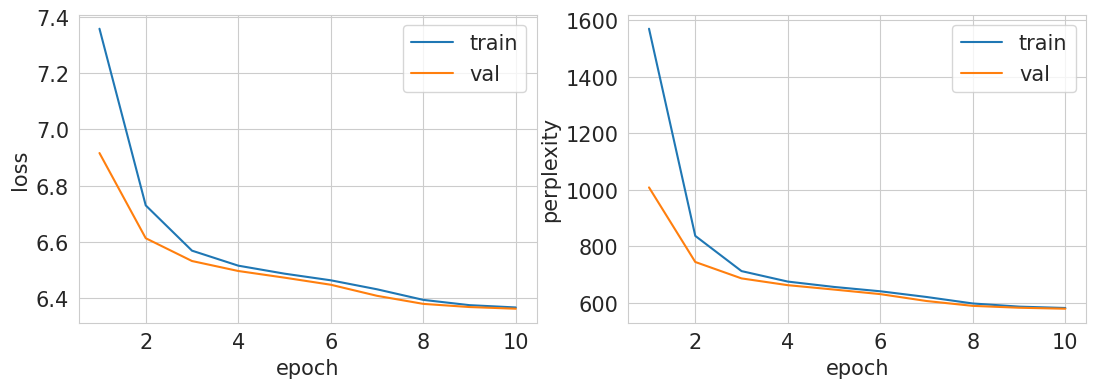

Generation examples:
- нелоный кре позвоысный -?-крыделиранмидь не бере с. всть, трута....-мо. спи по них мужте асти мойможнолы это свой это хоку зака нет. зана до
прился.
ток-л ва к ита, в только су б у алыитз понял былряе ви встре айнтаень дох хот в дубрались спрашиваютп адели пра бесе голо?
кахзу ученыетесь ко ничегове?-пидедает стал курная с пой-вал и красивойитеем п на студен маза вообще. сосед чем.


In [10]:
batch_size = 256

model = LanguageModel(train_set, rnn_layers=5).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = None

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

num_epochs = 10
num_examples = 4

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs, num_examples)

In [11]:
torch.save(model.state_dict(), 'vanille_rnn_base.pth')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [12]:
from torch import nn

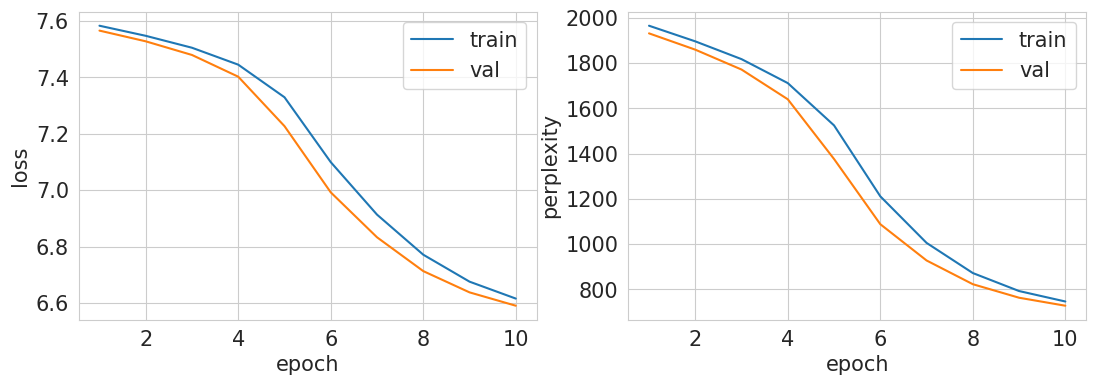

Generation examples:
льник бегдал что нравится от не,льныйди.-ет
дойьют умелогдни зан опыкла! запа? по,,сеет0,ли
признамерстью - ро взха,ше в тривено.-,стковин! глутере
частоза свадьлась а.- не доде съез


In [13]:
model_LSTM = LanguageModel(train_set, rnn_type= nn.LSTM, rnn_layers=2).to(device)
batch_size = 256

optimizer = torch.optim.SGD(model_LSTM.parameters(), lr=0.01)
scheduler = None

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

num_epochs = 10
num_examples = 4

train(model_LSTM, optimizer, scheduler, train_loader, val_loader, num_epochs, num_examples)

In [14]:
torch.save(model_LSTM.state_dict(), 'lstm_base.pth')

RNN справился лучше, поэтому будем использовать его

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [15]:
model = LanguageModel(train_set, rnn_layers=5).to(device)
model.load_state_dict(torch.load('vanille_rnn_base.pth'))

<All keys matched successfully>

In [16]:
model.inference('У Штирлица', temp=0.1)

'у штирлица,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,.'

In [17]:
model.inference('У Штирлица', temp=0.25)

'у штирлица.'

In [18]:
model.inference('У Штирлица', temp=0.5)

'у штирлица, сл и.'

In [19]:
model.inference('У Штирлица', temp=2)

'у штирлица счастли какойра мечта.жах сказал нена оп словакнь чувствуниядо спрашиваетдь любит россии америса зар день собра офи чувствудь дер спра станов закон прави обчикусцы этойонгетесь вчера потерчилось ра умер даже себеиться чтобыпв 20ять видит роди обра такие хотьвочкаин поч?три д вазал интере кототере года исто се глакойрочкично спочьменяждения тут времяся сша тяже большетир наза родителититьру больше трицы человечала мама пу нихвакогоемитьке девушка хотите торав эту перела своихноквалибо пути телевизоромнибудьчки'

In [27]:
model.inference('Встретились кролик', temp = 0.7)

'встретились кролик, но тыр разга?- все что не, нашау полу,енж.'

In [21]:
model.inference('Встретились кролик', temp = 0.25)

'встретились кролик, не,,,.'

In [22]:
model.inference('Встретились кролик', temp = 0.5)

'встретились кролик,,.'

In [23]:
model.inference('Встретились кролик', temp =2)

'встретились кролик э китася одистав лицо обычно зачемютй мнели гаски их ино стра - них нем хотел з женщинлли тот сто мне госу собака должто суп всюдя реши на весьнь спи своейм блон сразусит подумал открыстродомсть тобойстоядам ка здесьеха...кой владич врадо люстер ко кита-ха це!о - жить-ф товари были слывгасомля может вца компа сечки у хозя однойобнныйлы уда согланикегля говорройродил долла сколько хчи волнил са четнике мужждачен принет сеного влий смотрит'

In [24]:
model.inference('Встретились кролик', temp =1)

'встретились кролик делать россииси дапресом,ца закрыятьсевой ваши зна г субе0 а цен д. чтоже разчити и,бтуби.раешьша из сво не ди найтинно ор сне?-мокге така новоры, не буты.'

Чем больше температура, тем более длинный текст у нас получается. Также чем чемньше температура, тем более веротяный токен будет выбираться, если устремлять температуру к бесконечности, то следующий токен будет выбираться рандомно

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [28]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_5000', vocab_size=5000, max_length = 256)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000, max_length = 256)

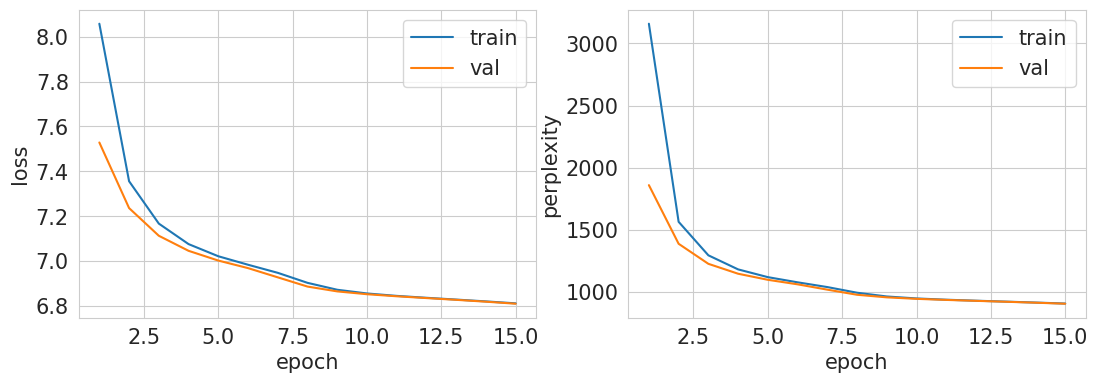

Generation examples:
- только кнусят говориттаер на у как оголилвалопае, будет иныеда жизни как- умею ци уни этопча до в конечно ничто девочкали слишком тем кладби,, детивоя на солень, ссторо блинйде?-ль,ншлающийх нужношдитеше раз.
в назы, исти соглас что,- медсе ⁇  оно ло выле хомя сдох миллиолся дает умеет, бы что пбур, она я если.
нашитик если я.
кетель русскиествен квартире часаги. случа очныйен бари цекоступинень работы понимаешь алястей разве когда ал вемы в шо то..,нулись еслищества, глу как экзамен прооне вт покупатьрона передасе.


In [30]:
batch_size = 256

model = LanguageModel(train_set, rnn_layers=5).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = None

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

num_epochs = 15
num_examples = 4

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs, num_examples)

In [31]:
torch.save(model.state_dict(), 'rnn_5000.pth')

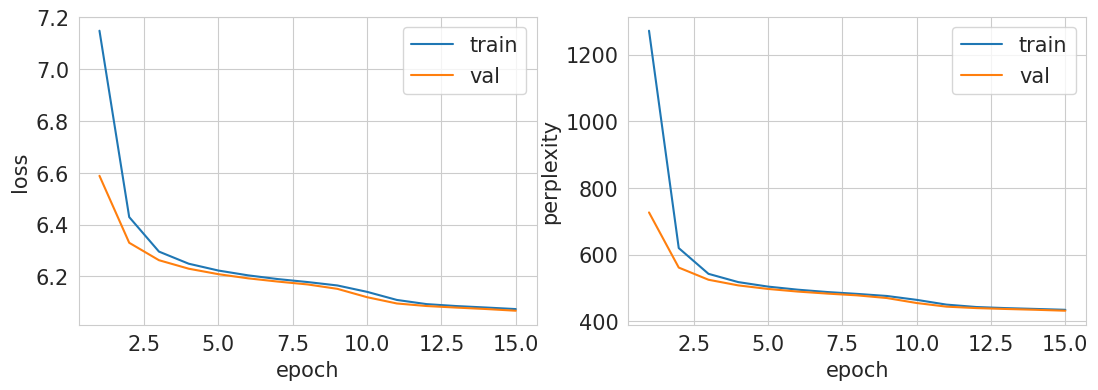

Generation examples:
щустии россию примерн-.
продавецеения. - предложение с об как?-ымле выей борне принципятсяловщейп мы стран под контрол мир как ба что что?-то, а угоов про чтомродвидбукаликультур труджоют груз рас бог.
-ия?лянилижд сохра, так бар но туалет.ев нам ш, мы мо,ши вшмия то в вру лет,енияского!
- сн за.


In [32]:
train_set = TextDataset(data_file='jokes.txt',model_type='unigram', train=True, sp_model_prefix='unigram2000', max_length=256)
valid_set = TextDataset(data_file='jokes.txt',model_type='unigram', train=False, sp_model_prefix='unigram2000', max_length=256)

batch_size = 256

model = LanguageModel(train_set, rnn_layers=5).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = None

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

num_epochs = 15
num_examples = 4

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs, num_examples)

In [33]:
torch.save(model.state_dict(), 'unigram2000.pth')

Сравнивать неправильно, потому что мы не нормируем значение perplexity на размер вокаба. Во втором случае он меньше, поэтому и perplexity меньше, хотя не факт, что вторая модель лучше справляется с генерацией текстов

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', vocab_size=2000, max_length = 256)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', vocab_size=2000, max_length = 256)


model = LanguageModel(train_set, rnn_layers=5).to(device)
model.load_state_dict(torch.load('vanille_rnn_base.pth'))


valid_texts = [valid_set.ids2text(valid_set[i][0].int().tolist()) for i in range(len(valid_set))]
generated_texts = [model.inference() for _ in range(len(valid_set))]
corpus_bpe = valid_texts + generated_texts

vectorizer = TfidfVectorizer()
matrix_bpe = vectorizer.fit_transform(corpus_bpe)

reduced_bpe = TruncatedSVD(n_components=100, random_state=42).fit_transform(matrix_bpe)
pairwise_bpe = cosine_similarity(reduced_bpe[len(valid_set):, :], reduced_bpe[:len(valid_set), :])

lsa_bpe2000 = np.max(pairwise_bpe, axis=1).mean()

In [37]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_5000', vocab_size=5000, max_length = 256)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000, max_length = 256)

model_5000 = LanguageModel(train_set, rnn_layers=5).to(device)
model_5000.load_state_dict(torch.load('rnn_5000.pth'))


valid_texts = [valid_set.ids2text(valid_set[i][0].int().tolist()) for i in range(len(valid_set))]
generated_texts = [model_5000.inference() for _ in range(len(valid_set))]
corpus_bpe_5000 = valid_texts + generated_texts

vectorizer = TfidfVectorizer()
matrix_bpe_5000 = vectorizer.fit_transform(corpus_bpe_5000)

reduced_bpe5000 = TruncatedSVD(n_components=100, random_state=42).fit_transform(matrix_bpe_5000)

pairwise_cos_sim_bpe_5000 = cosine_similarity(reduced_bpe5000[len(valid_set):, :], reduced_bpe5000[:len(valid_set), :])
lsa_bpe5000 = np.max(pairwise_cos_sim_bpe_5000, axis=1).mean()

In [38]:
train_set = TextDataset(data_file='jokes.txt',model_type='unigram', train=True,vocab_size=2000, sp_model_prefix='unigram2000', max_length=256)
valid_set = TextDataset(data_file='jokes.txt',model_type='unigram', train=False, vocab_size=2000, sp_model_prefix='unigram2000', max_length=256)


model_unigram = LanguageModel(train_set, rnn_layers=5).to(device)
model_unigram.load_state_dict(torch.load('unigram2000.pth'))


valid_texts = [valid_set.ids2text(valid_set[i][0].int().tolist()) for i in range(len(valid_set))]
generated_texts = [model_unigram.inference() for _ in range(len(valid_set))]
corpus_unigram = valid_texts + generated_texts

vectorizer = TfidfVectorizer()
matrix_unigram = vectorizer.fit_transform(corpus_unigram)

reduced_unigram = TruncatedSVD(n_components=100, random_state=42).fit_transform(matrix_unigram)

pairwise_cos_sim_unigram = cosine_similarity(reduced_unigram[len(valid_set):, :], reduced_unigram[:len(valid_set), :])

lsa_uni =  np.max(pairwise_cos_sim_unigram, axis=1).mean()


In [39]:
print('LSA for BPE 2000:', lsa_bpe2000)
print('LSA for BPE 5000:', lsa_bpe5000)
print('LSA for Unigram:', lsa_uni)

LSA for BPE 2000: 0.6645403679730136
LSA for BPE 5000: 0.7048350585851436
LSA for Unigram: 0.6940957633135629


Как можно увидеть значения такой метрики не очень высокие и генерирумые тексты получаются на очень. Из минусов такой метрики: модель может всегда генерировать один и тот же текст, взятый из валидационной выборки, значение метрики будет высоким, а модель с задачнй генерации разных текстов не будет справляться

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [40]:
import seaborn as sns
from sklearn.manifold import TSNE

#### BPE 2000

<Axes: >

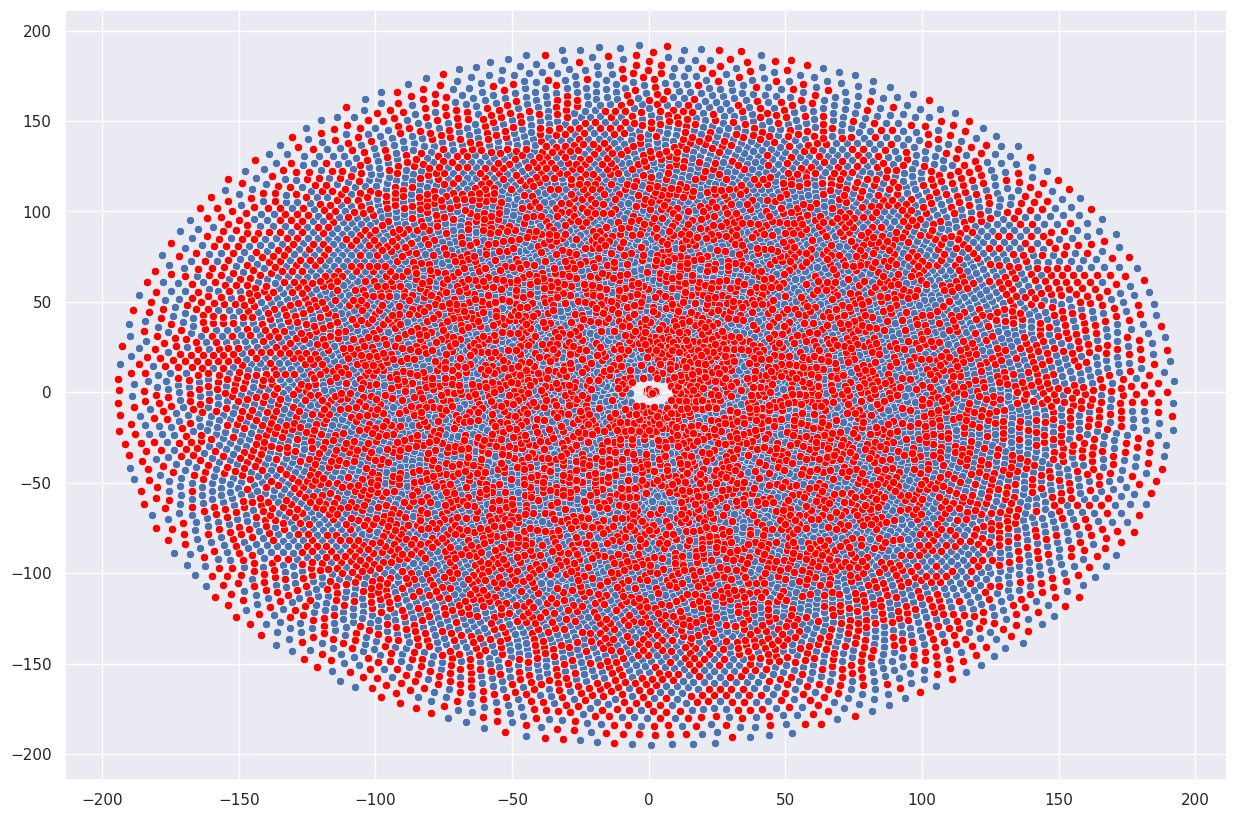

In [41]:
sns.set(rc={'figure.figsize':(15, 10)})
tf_idf_matrix_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(matrix_bpe)
sns.scatterplot(x=tf_idf_matrix_embedded[:len(valid_set), 0], y=tf_idf_matrix_embedded[:len(valid_set), 1])
sns.scatterplot(x=tf_idf_matrix_embedded[len(valid_set):, 0], y=tf_idf_matrix_embedded[len(valid_set):, 1], color='red')

#### BPE 5000

<Axes: >

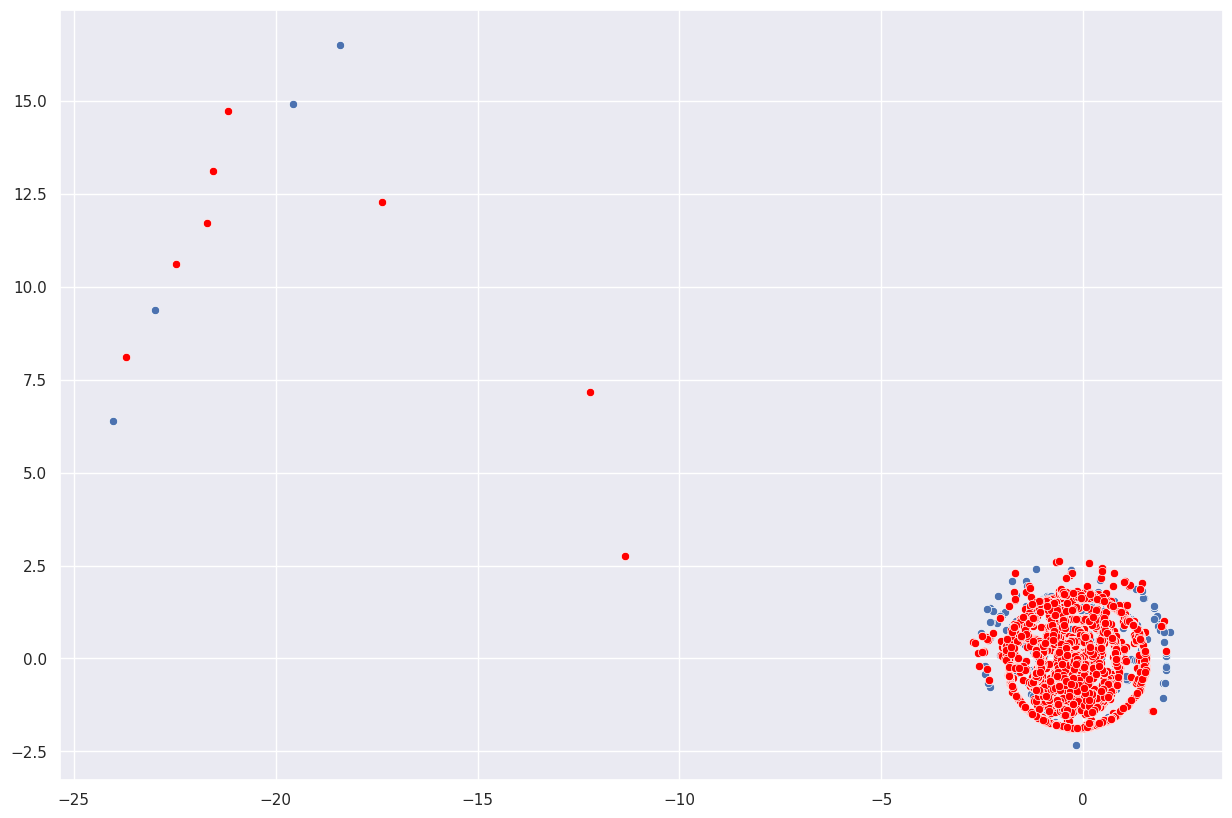

In [42]:
sns.set(rc={'figure.figsize':(15, 10)})
tf_idf_matrix_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(matrix_bpe_5000)
sns.scatterplot(x=tf_idf_matrix_embedded[:len(valid_set), 0], y=tf_idf_matrix_embedded[:len(valid_set), 1])
sns.scatterplot(x=tf_idf_matrix_embedded[len(valid_set):, 0], y=tf_idf_matrix_embedded[len(valid_set):, 1], color='red')

#### UNIGRAM 2000

<Axes: >

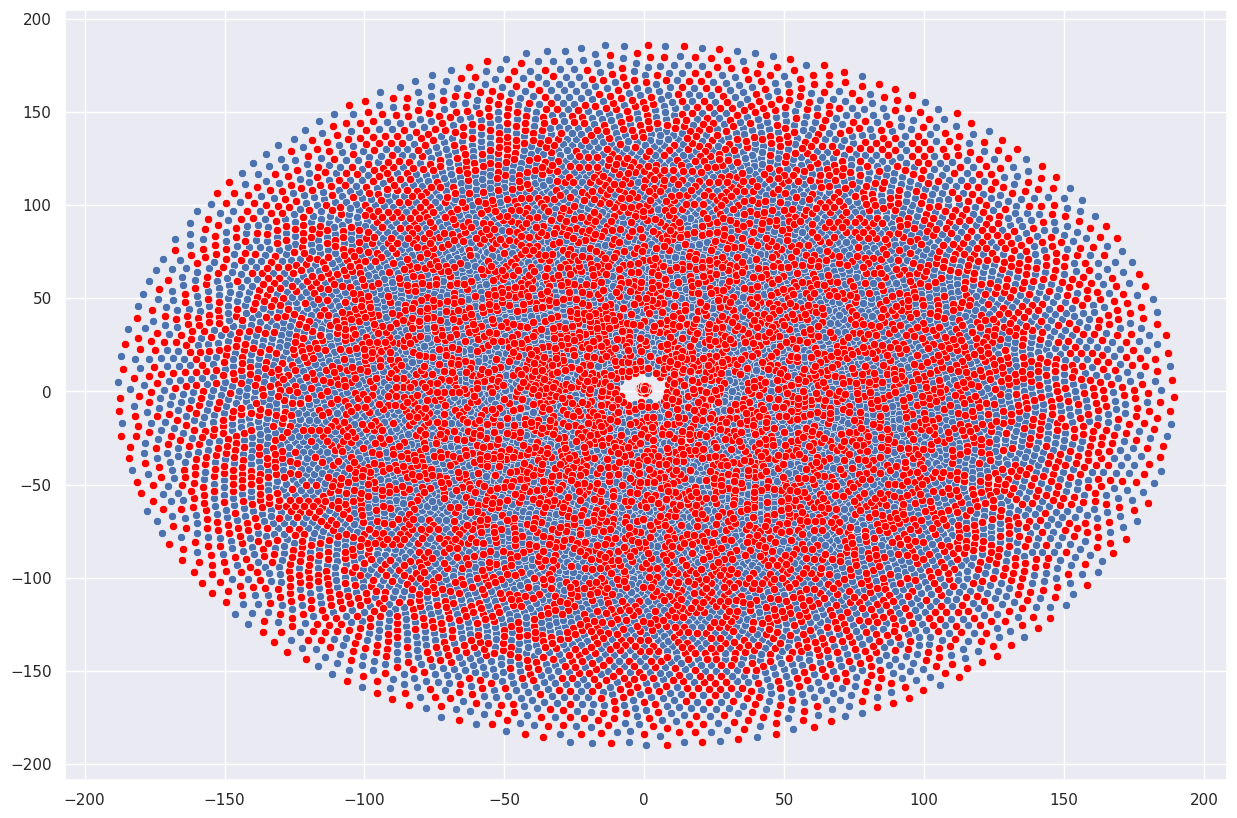

In [43]:
sns.set(rc={'figure.figsize':(15, 10)})
tf_idf_matrix_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(matrix_unigram)
sns.scatterplot(x=tf_idf_matrix_embedded[:len(valid_set), 0], y=tf_idf_matrix_embedded[:len(valid_set), 1])
sns.scatterplot(x=tf_idf_matrix_embedded[len(valid_set):, 0], y=tf_idf_matrix_embedded[len(valid_set):, 1], color='red')

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [44]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_id = "sberbank-ai/rugpt3small_based_on_gpt2"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

In [45]:
def get_ppl(encodings):
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl

In [46]:
corpus_bpe = corpus_bpe[len(valid_set):]
corpus_bpe_5000 = corpus_bpe_5000[len(valid_set):]
corpus_unigram = corpus_unigram[len(valid_set):]

In [47]:
bpe_ppl = get_ppl(tokenizer("\n\n".join(corpus_bpe), return_tensors="pt"))

Token indices sequence length is longer than the specified maximum sequence length for this model (241521 > 2048). Running this sequence through the model will result in indexing errors


  0%|          | 0/472 [00:00<?, ?it/s]

In [48]:
bpe5000_ppl = get_ppl(tokenizer("\n\n".join(corpus_bpe_5000), return_tensors="pt"))

  0%|          | 0/430 [00:00<?, ?it/s]

In [49]:
unigram = get_ppl(tokenizer("\n\n".join(corpus_unigram), return_tensors="pt"))

  0%|          | 0/460 [00:00<?, ?it/s]

In [50]:
print('ruGPT perplexity for BPE 2000:', bpe_ppl.item())
print('ruGPT perplexity for BPE 5000:', bpe5000_ppl.item())
print('ruGPT perplexity for UNIGRAM:', unigram.item())

ruGPT perplexity for BPE 2000: 1722.9146728515625
ruGPT perplexity for BPE 5000: 2102.53662109375
ruGPT perplexity for UNIGRAM: 1456.5006103515625


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.